# Group Project Report
### Group 19: Aidan Gallant, Alex Hachey, Cailey Murad, Caroline Ruus

## How Past Grades, Study Habits, and Absences Correlate to Final Math Grades

## Introduction:
- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

## Methods & Results:
- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- note: all tables and figure should have a figure/table number and a legend

In [37]:
library(tidyverse)
library(repr)
library(tidymodels)
library(rvest)
options(repr.matrix.max.rows = 6)

In [30]:
# load data from the original source on the web

temp <- tempfile()
temp2 <- tempfile()

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
download.file(url, temp)

unzip(zipfile = temp, exdir = temp2)

student <- read_csv2(file.path(temp2, "student-mat.csv"))
unlink(c(temp, temp2))

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



In [31]:
# wrangle and clean the data from it's original (downloaded) format to the format necessary for the planned 
# analysis

student <- student %>%
    as_tibble() %>%
    select (studytime, absences, G1, G2, G3)
student

studytime,absences,G1,G2,G3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,6,5,6,6
2,4,5,5,6
2,10,7,8,10
⋮,⋮,⋮,⋮,⋮
1,3,10,8,7
1,0,11,12,10
1,5,8,9,9


In [32]:
# perform a summary of the data set that is relevant for exploratory data analysis related to the planned 
# analysis 

set.seed(3456)

student_split <- initial_split(student, prop = 0.75, strata = studytime)  
student_train <- training(student_split)
student_test <- testing(student_split)

student_train

summary(student_train)

studytime,absences,G1,G2,G3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,6,5,6,6
2,4,5,5,6
2,10,7,8,10
⋮,⋮,⋮,⋮,⋮
1,3,14,16,16
1,3,10,8,7
1,0,11,12,10


   studytime        absences            G1              G2       
 Min.   :1.000   Min.   : 0.000   Min.   : 3.00   Min.   : 0.00  
 1st Qu.:1.000   1st Qu.: 0.000   1st Qu.: 8.00   1st Qu.: 8.00  
 Median :2.000   Median : 4.000   Median :10.00   Median :11.00  
 Mean   :2.037   Mean   : 6.027   Mean   :10.82   Mean   :10.65  
 3rd Qu.:2.000   3rd Qu.: 8.000   3rd Qu.:13.00   3rd Qu.:13.00  
 Max.   :4.000   Max.   :75.000   Max.   :19.00   Max.   :19.00  
       G3       
 Min.   : 0.00  
 1st Qu.: 8.00  
 Median :11.00  
 Mean   :10.36  
 3rd Qu.:14.00  
 Max.   :20.00  

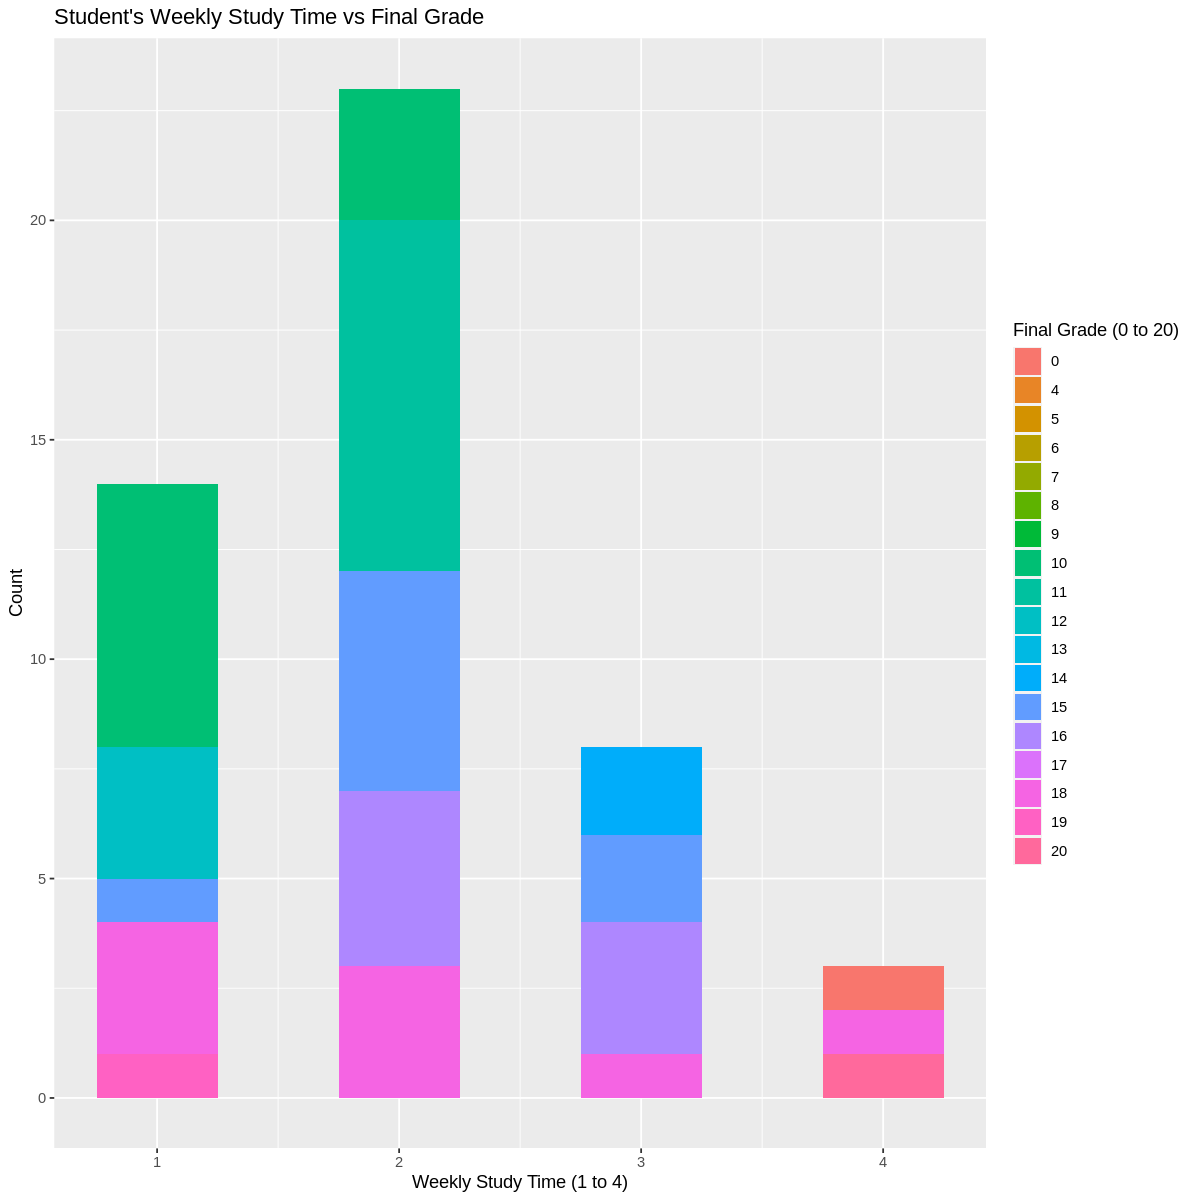

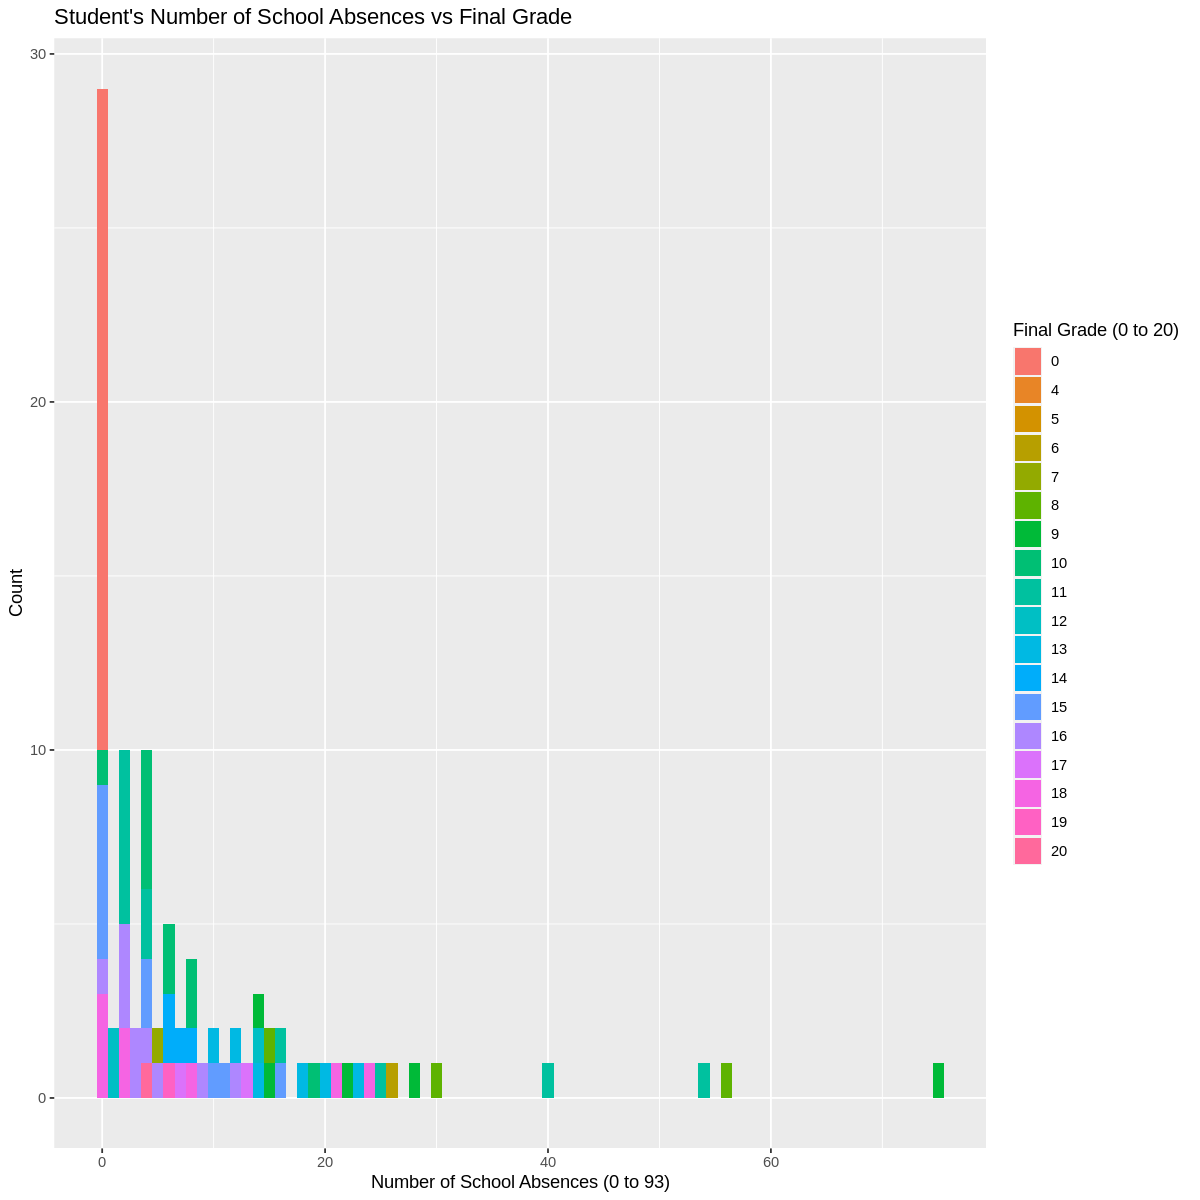

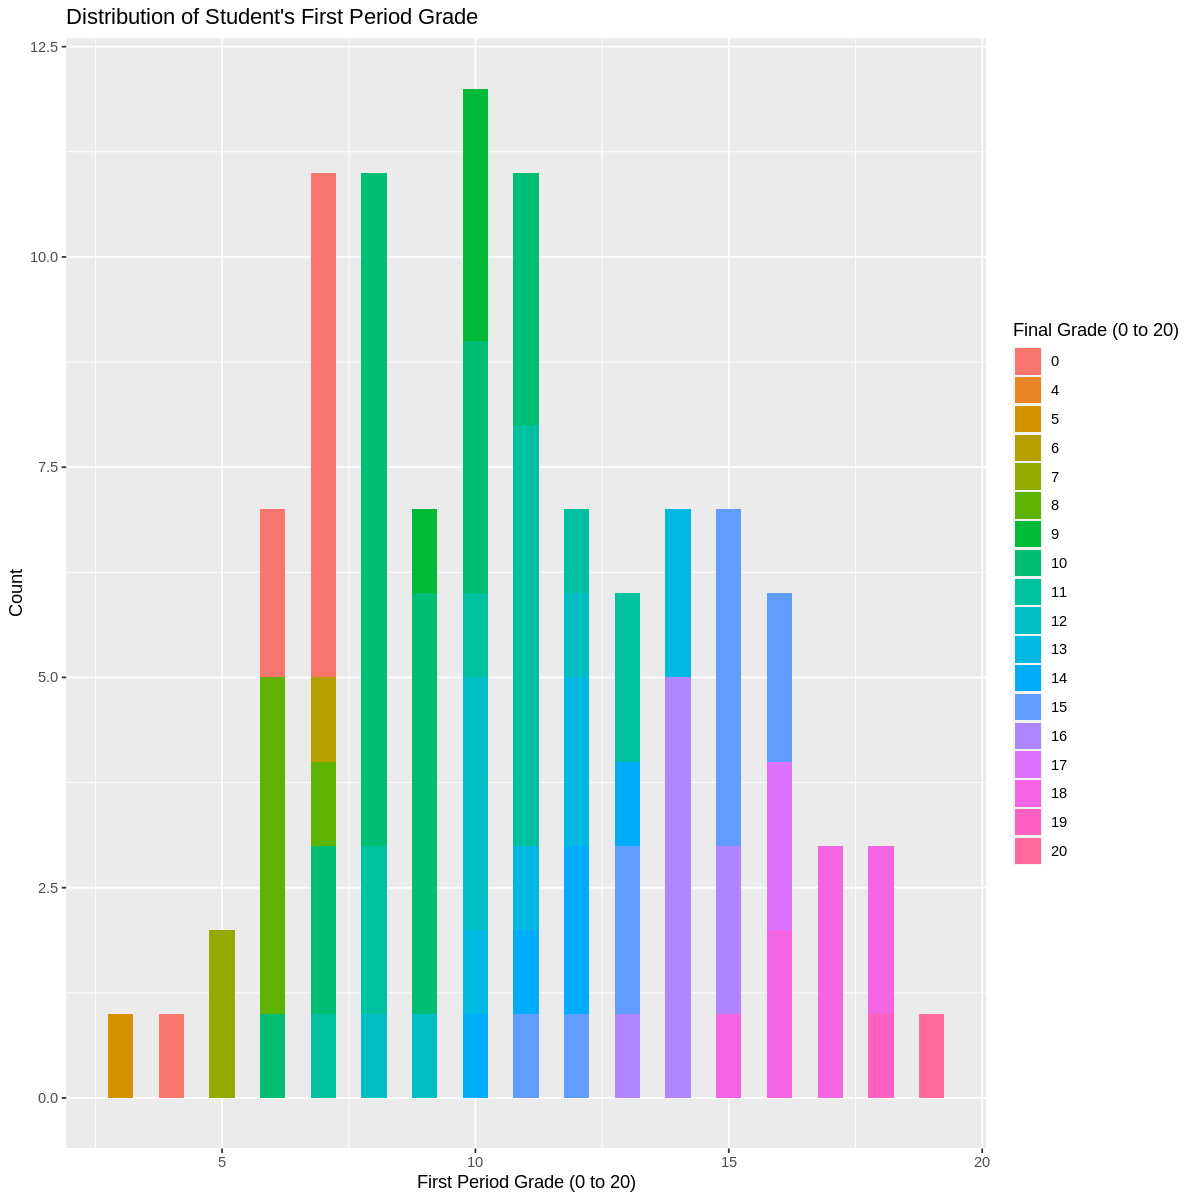

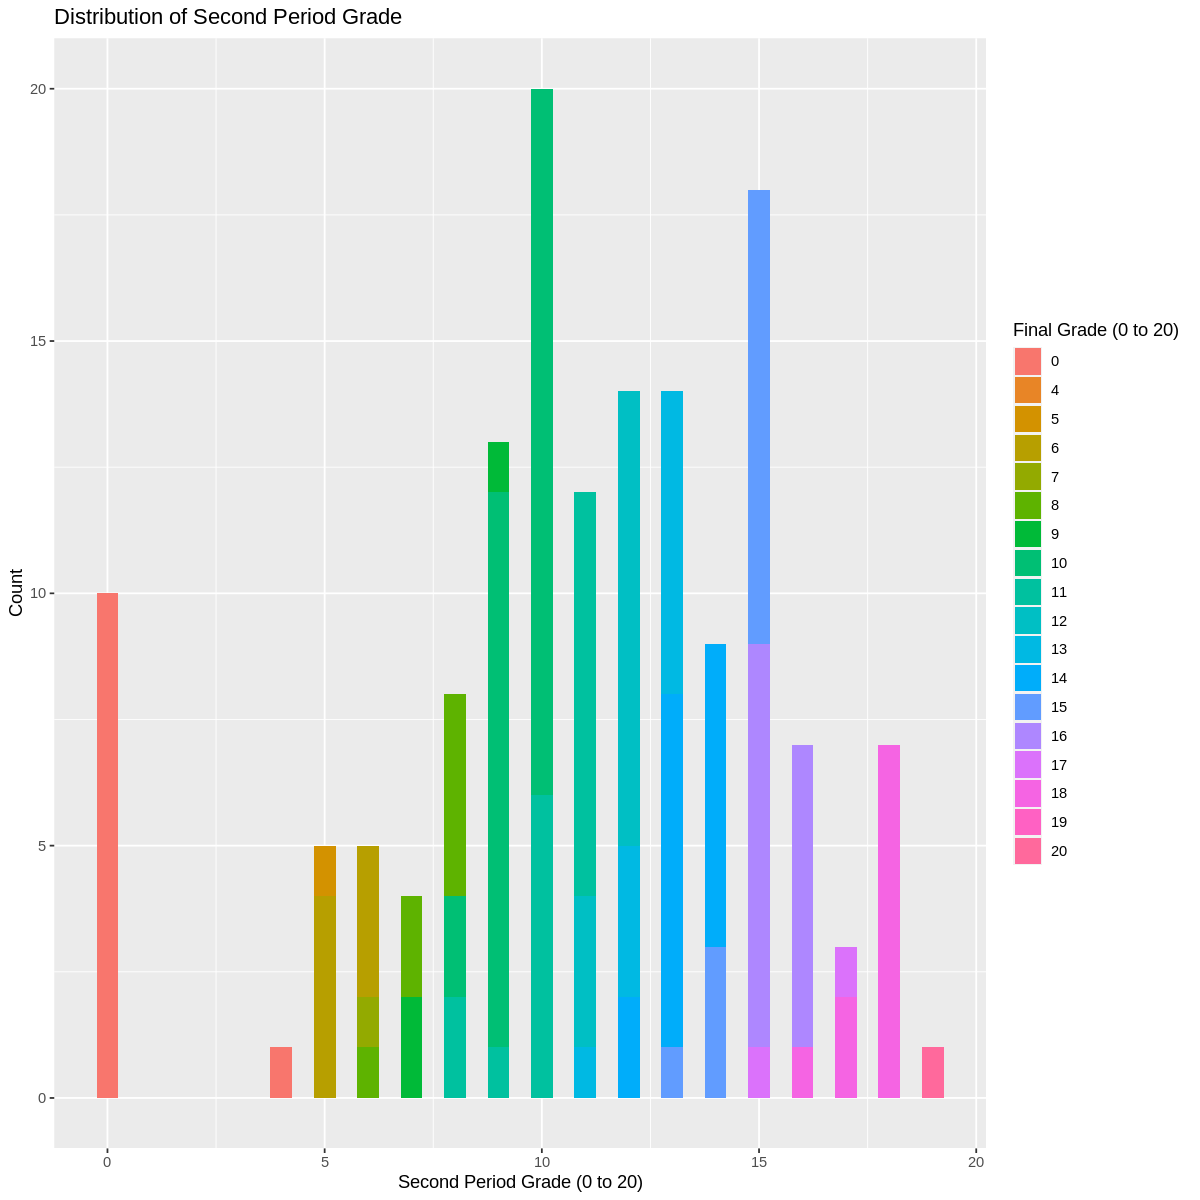

In [45]:
# create a visualization of the dataset that is relevant for exploratory data analysis related to the planned 
# analysis

studytime_plot <- student_train %>%
    ggplot(aes(x = studytime, fill = as_factor(G3))) +
    geom_histogram(position = "identity", binwidth = 0.5) +
    labs(x = "Weekly Study Time (1 to 4)", y = "Count", fill = "Final Grade (0 to 20)") +
    ggtitle("Student's Weekly Study Time vs Final Grade")

absences_plot <- student_train %>%
    ggplot(aes(x = absences, fill = as_factor(G3))) +
    geom_histogram(position = "identity", binwidth = 1) +
    labs(x = "Number of School Absences (0 to 93)", y = "Count", fill = "Final Grade (0 to 20)") +
    ggtitle("Student's Number of School Absences vs Final Grade")

G1_plot <- student_train %>%
    ggplot(aes(x = G1, fill = as_factor (G3))) +
    geom_histogram(position = "identity", binwidth = 0.5) +
    labs(x = "First Period Grade (0 to 20)", y = "Count", fill = "Final Grade (0 to 20)") +
    ggtitle("Distribution of Student's First Period Grade")

G2_plot <- student_train %>%
    ggplot(aes(x = G2, fill = as_factor (G3))) +
    geom_histogram(position = "identity", binwidth = 0.5) +
    labs(x = "Second Period Grade (0 to 20)", y = "Count", fill = "Final Grade (0 to 20)") +
    ggtitle("Distribution of Second Period Grade")

studytime_plot
absences_plot
G1_plot
G2_plot

In [7]:
# perform the data analysis
#Model specification:
student_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("regression")

#Create recipe to preprocess data
student_recipe <- recipe(G3 ~ G2, data = student_train) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())

#Cross-Validation to choose K
student_vfold <- vfold_cv(student_train, v = 10, strata = G3)

student_workflow <- workflow() %>%
add_recipe(student_recipe) %>%
add_model(student_spec)

gridvals <- tibble(neighbors = seq(1,50))

student_results <- student_workflow %>%
tune_grid(resamples = student_vfold, grid = gridvals) %>%
collect_metrics()

#Find min RMSPE
student_min <- student_results %>%
filter(.metric == "rmse") %>%
arrange(mean) %>% 
slice(1)

#Retrain model on training data using found K value
k_min <- student_min %>%
pull(neighbors)

student_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
set_engine("kknn") %>%
set_mode("regression")

student_best_fit <- workflow() %>%
add_recipe(student_recipe) %>%
add_model(student_best_spec) %>%
fit(data = student_train)

#Assess RMSPE of test data predictions
student_summary <- student_best_fit %>%
predict(student_testing) %>%
bind_cols(student_testing) %>%
metrics(truth = G3, estimate = .pred)

ERROR: Error in nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% : could not find function "%>%"


In [4]:
# create a visualization of the analysis 
#Visualize
student_preds <- student_best_fit %>%
    predict(student_train) %>%
    bind_cols(student_train)

student_plot <- ggplot(student_preds, aes(x=G2, y=G3)) +
    geom_point() +
    geom_line(data = student_preds, mapping = aes(x= G2, y= .pred), colour = "blue") +
    labs(x= "", y = "") +
    theme(text= element_text(size=20)) +
    ggtitle(paste0("K = ", k_min))
student_plot

ERROR: Error in student_best_fit %>% predict(student_train) %>% bind_cols(student_train): could not find function "%>%"


## Discussion:
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

## References
- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
- Make sure to cite the source of your data as well.